In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

% matplotlib inline

In [3]:
# load in us trending videos & category ids
trending_videos = pd.read_csv("youtube-new/USvideos.csv")
trending_videos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [4]:
category_ids = pd.read_json("youtube-new/US_category_id.json")
category_ids.head()

,kind,etag,items
0,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
1,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
2,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
3,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
4,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."


In [7]:
trending_videos.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')

In [5]:
def publish_month(publish_time):
    return publish_time[5:7]

def publish_hour(publish_time):
    return publish_time[11:13]

In [26]:
# f(channel_title | )

channel_title_distr = {}

for i in range(len(trending_videos)):
    curr_row = trending_videos.iloc[i, ]
    
    channel_title = curr_row.channel_title
    category_id = curr_row.category_id
    pub_month = publish_month(curr_row.publish_time)
    pub_hour = publish_hour(curr_row.publish_time)
    comments_disabled = curr_row.comments_disabled
    ratings_disabled = curr_row.ratings_disabled
    video_err = curr_row.video_error_or_removed
    
    curr_key = (category_id, pub_month, pub_hour, comments_disabled, ratings_disabled, video_err)
    
    if curr_key in channel_title_distr:
        if channel_title in channel_title_distr[curr_key]:
            channel_title_distr[curr_key][channel_title] += 1
        else:
            channel_title_distr[curr_key][channel_title] = 1
    else:
        channel_title_distr[curr_key] = {channel_title: 1}
    
print(channel_title_distr[(22, '11', '17', False, False, False)])

{'CaseyNeistat': 14, 'Estée Lalonde': 3, 'Daelric': 2, 'Ellie and Jared': 7, 'CIRCUITBEARD': 1}


In [18]:
def views_cond_distr(other_x):
#     theta_1, theta_2, theta_3, theta_4, theta_5 = other_x
    theta_1, theta_2 = other_x
    theta_0_freqs = {}
    
    for i in range(len(trending_videos)):
        curr_row = trending_videos.iloc[i, ]
        
        likes = curr_row.likes
        
        views = curr_row.views
        pub_month = int(publish_month(curr_row.publish_time))
        pub_hour = int(publish_hour(curr_row.publish_time))
#         comments_disabled = -1 if curr_row.comments_disabled else 1
#         ratings_disabled = -1 if curr_row.ratings_disabled else 1
#         video_err = -1 if curr_row.video_error_or_removed else 1
        
#         theta_0 = (likes - theta_1 * pub_month - theta_2 * pub_hour - theta_3 * comments_disabled - theta_4 * ratings_disabled - theta_5 * video_err) / views
        theta_0 = (likes - theta_1 * pub_month - theta_2 * pub_hour) / views
        
        if theta_0 in theta_0_freqs:
            theta_0_freqs[theta_0] += 1
        else:
            theta_0_freqs[theta_0] = 1
    return theta_0_freqs

ex_distr = views_cond_distr([1, 1])

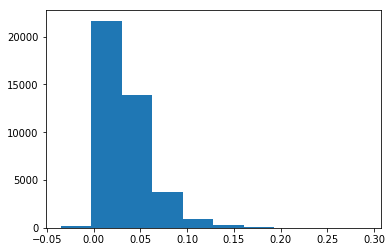

In [19]:
distr_list = []

for k, v in ex_distr.items():
    for _ in range(v):
        distr_list += [k]

plt.hist(distr_list)
plt.show()

In [20]:
theta_0_sample = np.random.choice(distr_list)
print(theta_0_sample)

0.007753335421072746


In [21]:
def cond_sample(cond_distr, other_x, enable_plot = False):
    distr = cond_distr(other_x)
    distr_list = []
    for k, v in distr.items():
        for _ in range(v):
            distr_list += [k]
    if enable_plot:
        plt.hist(distr_list)
        plt.show()
    return np.random.choice(distr_list)

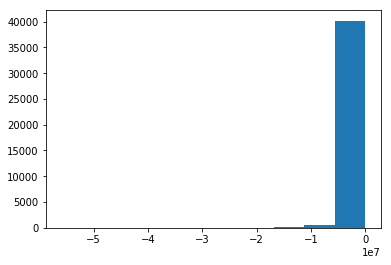

-458712.6

In [24]:
def pub_month_cond_distr(other_x):
#     theta_0, theta_2, theta_3, theta_4, theta_5 = other_x
    theta_0, theta_2 = other_x
    theta_1_freqs = {}
    
    for i in range(len(trending_videos)):
        curr_row = trending_videos.iloc[i, ]
        
        likes = curr_row.likes
        
        views = curr_row.views
        pub_month = int(publish_month(curr_row.publish_time))
        pub_hour = int(publish_hour(curr_row.publish_time))
#         comments_disabled = -1 if curr_row.comments_disabled else 1
#         ratings_disabled = -1 if curr_row.ratings_disabled else 1
#         video_err = -1 if curr_row.video_error_or_removed else 1
        
#         theta_1 = (likes - theta_0 * views - theta_2 * pub_hour - theta_3 * comments_disabled - theta_4 * ratings_disabled - theta_5 * video_err) / pub_month
        theta_1 = (likes - theta_0 * views - theta_2 * pub_hour) / pub_month

        if theta_1 in theta_1_freqs:
            theta_1_freqs[theta_1] += 1
        else:
            theta_1_freqs[theta_1] = 1
    return theta_1_freqs

cond_sample(pub_month_cond_distr, [1, 1], enable_plot = True)

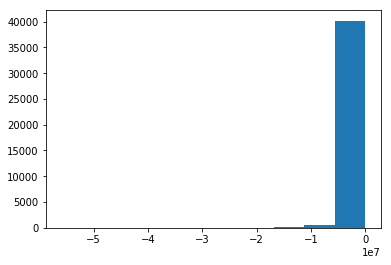

-348560.0

In [26]:
def pub_hour_cond_distr(other_x):
#     theta_0, theta_1, theta_3, theta_4, theta_5 = other_x
    theta_0, theta_1 = other_x

    theta_2_freqs = {}
    
    for i in range(len(trending_videos)):
        curr_row = trending_videos.iloc[i, ]
        
        likes = curr_row.likes
        
        views = curr_row.views
        pub_month = int(publish_month(curr_row.publish_time))
        pub_hour = int(publish_hour(curr_row.publish_time)) + 1
#         comments_disabled = -1 if curr_row.comments_disabled else 1
#         ratings_disabled = -1 if curr_row.ratings_disabled else 1
#         video_err = -1 if curr_row.video_error_or_removed else 1
        
#         theta_2 = (likes - theta_0 * views - theta_1 * pub_month - theta_3 * comments_disabled - theta_4 * ratings_disabled - theta_5 * video_err) / pub_hour
        theta_2 = (likes - theta_0 * views - theta_1 * pub_month) / pub_hour
        
        if theta_2 in theta_2_freqs:
            theta_2_freqs[theta_2] += 1
        else:
            theta_2_freqs[theta_2] = 1
    return theta_2_freqs

cond_sample(pub_month_cond_distr, [1, 1], enable_plot = True)

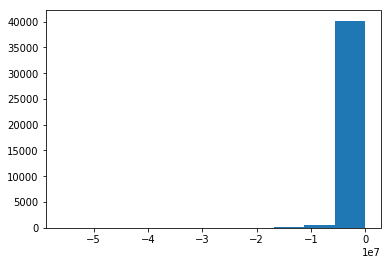

-62699.72727272727

In [12]:
def comments_disabled_cond_distr(other_x):
    theta_0, theta_1, theta_2, theta_4, theta_5 = other_x
    theta_3_freqs = {}
    
    for i in range(len(trending_videos)):
        curr_row = trending_videos.iloc[i, ]
        
        likes = curr_row.likes
        
        views = curr_row.views
        pub_month = int(publish_month(curr_row.publish_time))
        pub_hour = int(publish_hour(curr_row.publish_time))
        comments_disabled = -1 if curr_row.comments_disabled else 1
        ratings_disabled = -1 if curr_row.ratings_disabled else 1
        video_err = -1 if curr_row.video_error_or_removed else 1
        
        theta_3 = (likes - theta_0 * views - theta_1 * pub_month - theta_2 * pub_hour - theta_4 * ratings_disabled - theta_5 * video_err) / comments_disabled
        
        if theta_3 in theta_3_freqs:
            theta_3_freqs[theta_3] += 1
        else:
            theta_3_freqs[theta_3] = 1
    return theta_3_freqs

cond_sample(pub_month_cond_distr, [1, 1, 1, 1, 1], enable_plot = True)

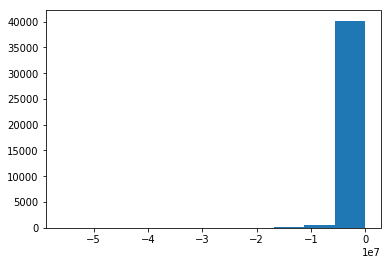

-32204.5

In [13]:
def ratings_disabled_cond_distr(other_x):
    theta_0, theta_1, theta_2, theta_3, theta_5 = other_x
    theta_4_freqs = {}
    
    for i in range(len(trending_videos)):
        curr_row = trending_videos.iloc[i, ]
        
        likes = curr_row.likes
        
        views = curr_row.views
        pub_month = int(publish_month(curr_row.publish_time))
        pub_hour = int(publish_hour(curr_row.publish_time))
        comments_disabled = -1 if curr_row.comments_disabled else 1
        ratings_disabled = -1 if curr_row.ratings_disabled else 1
        video_err = -1 if curr_row.video_error_or_removed else 1
        
        theta_4 = (likes - theta_0 * views - theta_1 * pub_month - theta_2 * pub_hour - theta_3 * comments_disabled - theta_5 * video_err) / ratings_disabled
        
        if theta_4 in theta_4_freqs:
            theta_4_freqs[theta_4] += 1
        else:
            theta_4_freqs[theta_4] = 1
    return theta_4_freqs

cond_sample(pub_month_cond_distr, [1, 1, 1, 1, 1], enable_plot = True)

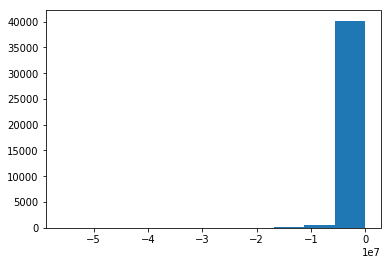

-2718.2

In [14]:
def video_err_cond_distr(other_x):
    theta_0, theta_1, theta_2, theta_3, theta_4 = other_x
    theta_5_freqs = {}
    
    for i in range(len(trending_videos)):
        curr_row = trending_videos.iloc[i, ]
        
        likes = curr_row.likes
        
        views = curr_row.views
        pub_month = int(publish_month(curr_row.publish_time))
        pub_hour = int(publish_hour(curr_row.publish_time))
        comments_disabled = -1 if curr_row.comments_disabled else 1
        ratings_disabled = -1 if curr_row.ratings_disabled else 1
        video_err = -1 if curr_row.video_error_or_removed else 1
        
        theta_5 = (likes - theta_0 * views - theta_1 * pub_month - theta_2 * pub_hour - theta_3 * comments_disabled - theta_4 * ratings_disabled) / video_err
        
        if theta_5 in theta_5_freqs:
            theta_5_freqs[theta_5] += 1
        else:
            theta_5_freqs[theta_5] = 1
    return theta_5_freqs

cond_sample(pub_month_cond_distr, [1, 1, 1, 1, 1], enable_plot = True)

In [ ]:
# initial values
# [views, pub_month, pub_hour, comments_disabled, ratings_disabled, video_error_or_removed]
# x = [1, 1, 1, 1, 1, 1]
x = [1, 1, 1]

# start the MCMC sampler
for i in range(1000):
    x[0] = cond_sample(views_cond_distr, x[1:])
    x[1] = cond_sample(pub_month_cond_distr, [x[0]] + x[2:])
    x[2] = cond_sample(pub_hour_cond_distr, [x[0], x[1]] + x[3:])
#     x[3] = cond_sample(comments_disabled_cond_distr, [x[0], x[1], x[2]] + x[4:])
#     x[4] = cond_sample(ratings_disabled_cond_distr, [x[0], x[1], x[2], x[3]] + x[5:])
#     x[5] = cond_sample(video_err_cond_distr, [x[0], x[1], x[2], x[3], x[4]])

print(x)

/Users/lilybhattacharjee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
/Users/lilybhattacharjee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
/Users/lilybhattacharjee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [35]:
19689494.96941807 * 748374 - 3060116626424.522 * 6 + 92682204825.60863 * 17

-2049996168268.5068